# Using Gurobi to Solve Optimization Problems

---

## A) 

Solving the model.

---

In [10]:
import numpy as np
from gurobipy import Model, GRB, quicksum

# Supply at each plant
capacity = [1500, 801, 1190, 2900, 1250]

# Demand at each distribution center
demand = [520, 800, 300, 1450, 375, 100, 935, 750, 620]

plants = range(len(capacity))
dcs = range(len(demand))

M = 1e12  # A large number

# Transportation costs matrix
cost = [
    [180, 215, 65, 55, 105, 110, 100, 125, 155],
    [110, 175, 95, 145, 165, 120, 80, 160, 205],
    [145, 165, 150, 95, 150, 180, 195, 120, 135],
    [180, 220, 175, 365, 190, 185, 155, 265, 290],
    [135, 165, 160, 65, 130, 150, M, M, M] # M is used to represent infeasible routes
]

# Create a Gurobi model
model = Model("TransportationProblem")

# Decision variables: x[i, j] is the amount shipped from plant i to DC j
x = model.addVars(len(plants), len(dcs), obj=cost, name="x", vtype=GRB.CONTINUOUS)

# Add constraints
# Demand constraints: Sum of shipments to each DC must meet its demand
model.addConstrs((quicksum(x[i, j] for i in range(len(plants))) >= demand[j] for j in range(len(dcs))), name="Demand")

# Supply constraints: Sum of shipments from each plant cannot exceed its capacity
model.addConstrs((quicksum(x[i, j] for j in range(len(dcs))) <= capacity[i] for i in range(len(plants))), name="Capacity")

# Optimize the model
model.optimize()

# Print results
if model.status == GRB.OPTIMAL:
    print(f"Optimal cost: {model.objVal}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 14 rows, 45 columns and 90 nonzeros
Model fingerprint: 0x2797df4d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+01, 1e+12]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 3e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 14 rows, 45 columns, 90 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.850000e+03   0.000000e+00      0s
      17    6.6875000e+05   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.687500000e+05
Optimal cost: 668750.0


In [11]:
import csv

# Create a mapping for plants to letters
plant_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# Save results to a CSV file
print(["Optimal cost", model.objVal])
with open("hw3-1-a-soln.csv", "w", newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Plant", "DC", "Units Shipped"])
    if model.status == GRB.OPTIMAL:
        for i in range(len(plants)):
            for j in range(len(dcs)):
                if x[i, j].x > 0:
                    print(f"Ship {x[i, j].x} units from Plant {plant_to_letter[plants[i]]} to DC {dcs[j]+1}")
                    csvwriter.writerow([plant_to_letter[plants[i]], dcs[j]+1, x[i, j].x])
    else:
        csvwriter.writerow(["No optimal solution found"])


['Optimal cost', 668750.0]
Ship 300.0 units from Plant A to DC 3
Ship 545.0 units from Plant A to DC 4
Ship 375.0 units from Plant A to DC 5
Ship 100.0 units from Plant A to DC 6
Ship 180.0 units from Plant A to DC 8
Ship 801.0 units from Plant B to DC 7
Ship 570.0 units from Plant C to DC 8
Ship 620.0 units from Plant C to DC 9
Ship 520.0 units from Plant D to DC 1
Ship 455.0 units from Plant D to DC 2
Ship 134.0 units from Plant D to DC 7
Ship 345.0 units from Plant E to DC 2
Ship 905.0 units from Plant E to DC 4


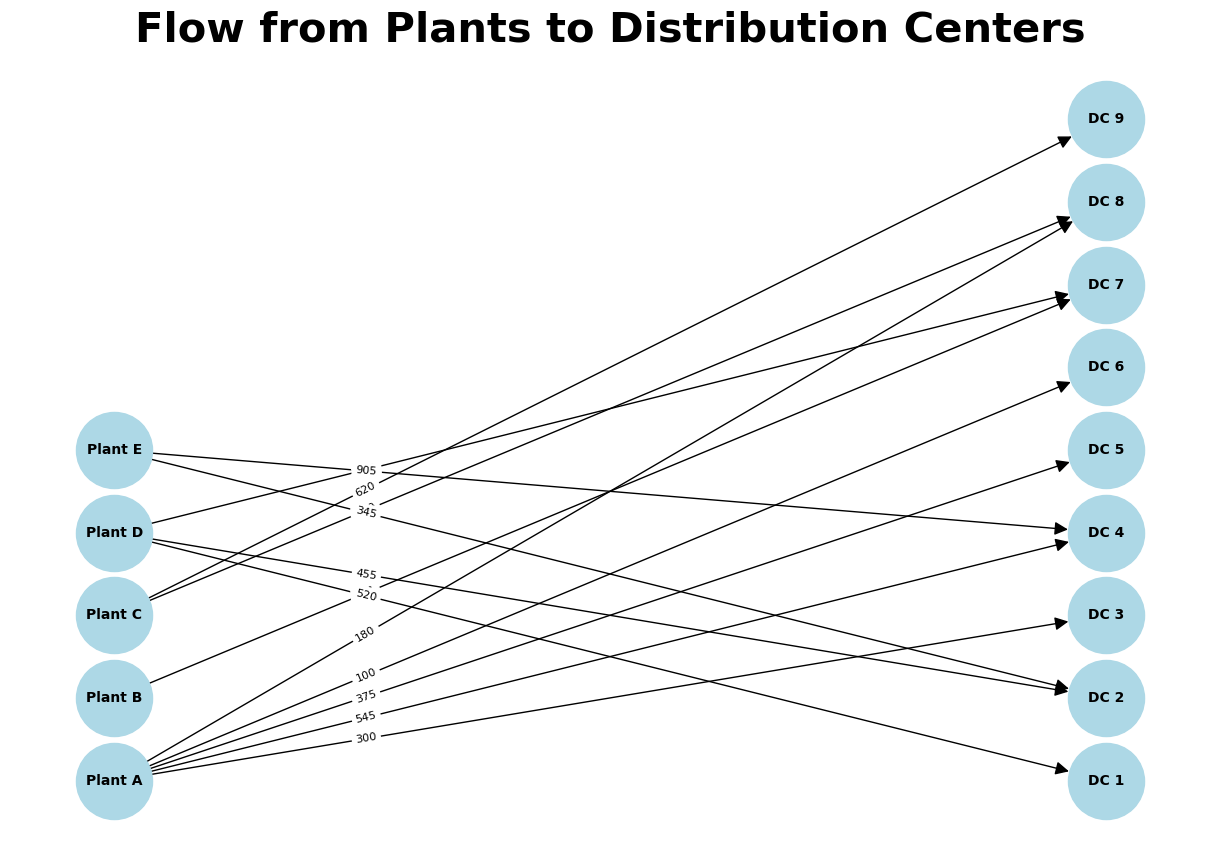

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes for plants and DCs
plant_nodes = [f'Plant {plant_to_letter[i]}' for i in plants]
dc_nodes = [f'DC {j+1}' for j in dcs]
G.add_nodes_from(plant_nodes, bipartite=0)
G.add_nodes_from(dc_nodes, bipartite=1)

# Add edges with flow values
edges = []
for i in plants:
    for j in dcs:
        if x[i, j].x > 0:
            edges.append((f'Plant {plant_to_letter[i]}', f'DC {j+1}', x[i, j].x))

G.add_weighted_edges_from(edges)

# Position nodes using bipartite layout
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(plant_nodes))
pos.update((node, (2, index)) for index, node in enumerate(dc_nodes))

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
# Adjust the position of edge labels to avoid overlap
edge_labels = {(u, v): f'{d["weight"]:.0f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.25)
plt.title('Flow from Plants to Distribution Centers', fontsize=30, fontweight='bold')
plt.show()


---

## B)

Explanation of high cost edge usage.

---

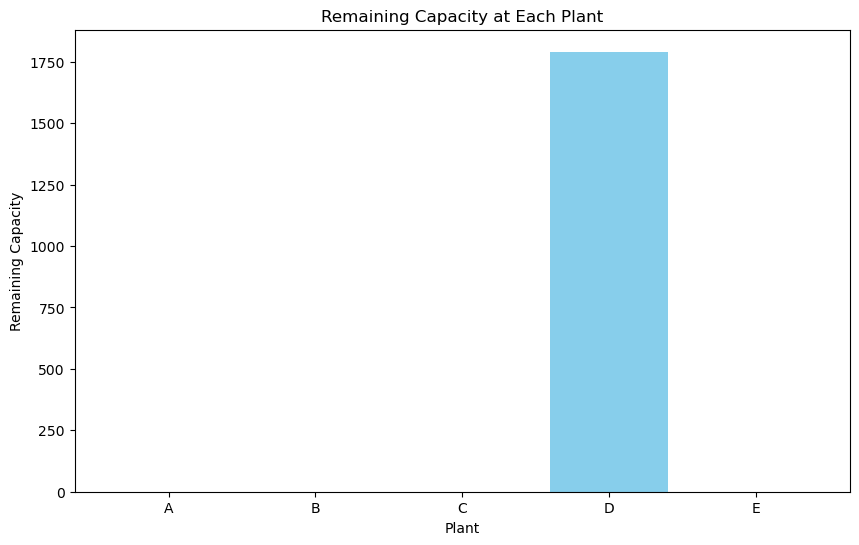

Remaining capacity at Plant A: 0.0
Remaining capacity at Plant B: 0.0
Remaining capacity at Plant C: 0.0
Remaining capacity at Plant D: 1791.0
Remaining capacity at Plant E: 0.0


In [13]:
remaining_capacity = [capacity[i] - sum(x[i, j].x for j in dcs) for i in plants]

# Visualize remaining capacity in a single bar graph
plt.figure(figsize=(10, 6))
plt.bar([plant_to_letter[i] for i in plants], remaining_capacity, color='skyblue')
plt.xlabel('Plant')
plt.ylabel('Remaining Capacity')
plt.title('Remaining Capacity at Each Plant')
plt.show()

# Print remaining capacity for each plant
for i in plants:
    print(f"Remaining capacity at Plant {plant_to_letter[i]}: {remaining_capacity[i]}")

---

## C)

How much would we pay for an additional unit of capacity from D?

This would be the shadow price.

---

Shadow price for Demand[0]: 180.0
Shadow price for Demand[1]: 220.0
Shadow price for Demand[2]: 130.0
Shadow price for Demand[3]: 120.0
Shadow price for Demand[4]: 170.0
Shadow price for Demand[5]: 175.0
Shadow price for Demand[6]: 155.0
Shadow price for Demand[7]: 190.0
Shadow price for Demand[8]: 205.0
Shadow price for Capacity[0]: -65.0
Shadow price for Capacity[1]: -75.0
Shadow price for Capacity[2]: -70.0
Shadow price for Capacity[3]: 0.0
Shadow price for Capacity[4]: -55.0


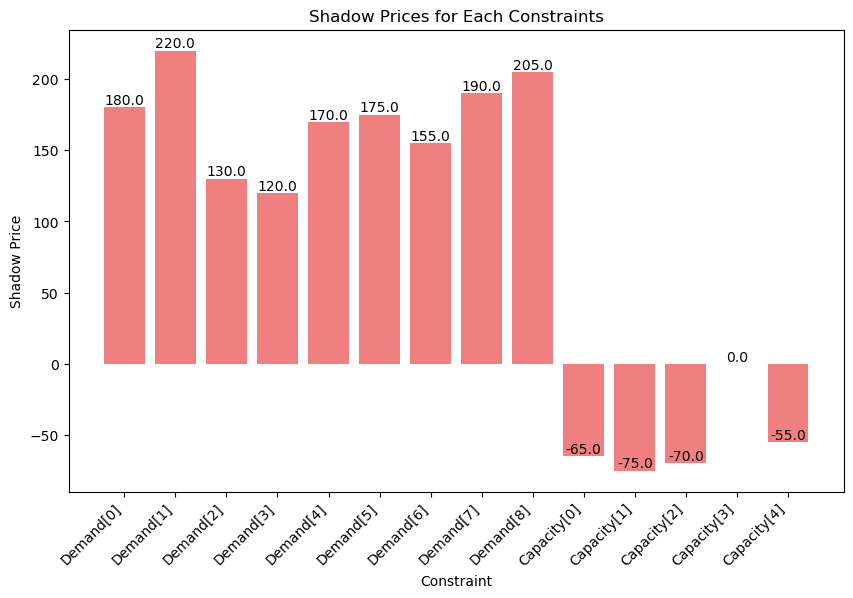

In [14]:
# Get the shadow prices for the capacity constraints
shadow_prices = model.getAttr(GRB.Attr.Pi, model.getConstrs())

# Print the shadow prices for the capacity constraints
for i, constr in enumerate(model.getConstrs()):
    print(f"Shadow price for {constr.ConstrName}: {shadow_prices[i]}")

# Visualize shadow prices in a bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar([constr.ConstrName for constr in model.getConstrs()], shadow_prices, color='lightcoral')
plt.xlabel('Constraint')
plt.ylabel('Shadow Price')
plt.title('Shadow Prices for Each Constraints')

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()